# Generative AI Use Case: Summarize Dialogue

Welcome to the practical side of this course. In this lab you will do the dialogue summarization task using generative AI. You will explore how the input text affects the output of the model, and perform prompt engineering to direct it towards the task you need. By comparing zero shot, one shot, and few shot inferences, you will take the first step towards prompt engineering and see how it can enhance the generative output of Large Language Models.

# Table of Contents

- [ 1 - Set up Kernel and Required Dependencies](#1)
- [ 2 - Summarize Dialogue without Prompt Engineering](#2)
- [ 3 - Summarize Dialogue with an Instruction Prompt](#3)
  - [ 3.1 - Zero Shot Inference with an Instruction Prompt](#3.1)
  - [ 3.2 - Zero Shot Inference with the Prompt Template from FLAN-T5](#3.2)
- [ 4 - Summarize Dialogue with One Shot and Few Shot Inference](#4)
  - [ 4.1 - One Shot Inference](#4.1)
  - [ 4.2 - Few Shot Inference](#4.2)
- [ 5 - Generative Configuration Parameters for Inference](#5)


<a name='1'></a>
## 1 - Set up Kernel and Required Dependencies

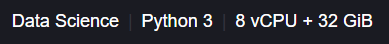First, check that the correct kernel is chosen.

<img src="images/kernel_set_up.png" width="300"/>

You can click on that (top right of the screen) to see and check the details of the image, kernel, and instance type.

<img src="images/w1_kernel_and_instance_type.png" width="600"/>




Now install the required packages to use PyTorch and Hugging Face transformers and datasets.



In [2]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0  --quiet

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00:00:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer ver

Load the datasets, Large Language Model (LLM), tokenizer, and configurator. Do not worry if you do not understand yet all of those components - they will be described and discussed later in the notebook.

In [3]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig

<a name='2'></a>
## 2 - Summarize Dialogue without Prompt Engineering

In this use case, you will be generating a summary of a dialogue with the pre-trained Large Language Model (LLM) FLAN-T5 from Hugging Face. The list of available models in the Hugging Face `transformers` package can be found [here](https://huggingface.co/docs/transformers/index). 

Let's upload some simple dialogues from the [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) Hugging Face dataset. This dataset contains 10,000+ dialogues with the corresponding manually labeled summaries and topics. 

In [4]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-3005b557c2c04c1d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Print a couple of dialogues with their baseline summaries.

In [5]:
example_indices = [40, 200]

dash_line = '-'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT DIALOGUE:')
    print(dataset['test'][index]['dialogue'])
    print(dash_line)
    print('BASELINE HUMAN SUMMARY:')
    print(dataset['test'][index]['summary'])
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT DIALOGUE:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Exa

Load the [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5), creating an instance of the `AutoModelForSeq2SeqLM` class with the `.from_pretrained()` method. 

In [6]:
model_name='google/flan-t5-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

To perform encoding and decoding, you need to work with text in a tokenized form. **Tokenization** is the process of splitting texts into smaller units that can be processed by the LLM models. 

Download the tokenizer for the FLAN-T5 model using `AutoTokenizer.from_pretrained()` method. Parameter `use_fast` switches on fast tokenizer. At this stage, there is no need to go into the details of that, but you can find the tokenizer parameters in the [documentation](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/auto#transformers.AutoTokenizer).

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

Test the tokenizer encoding and decoding a simple sentence:

In [8]:
sentence = "What time is it, Tom?"

sentence_encoded = tokenizer(sentence, return_tensors='pt')

sentence_decoded = tokenizer.decode(
        sentence_encoded["input_ids"][0], 
        skip_special_tokens=True
    )

print('ENCODED SENTENCE:')
print(sentence_encoded["input_ids"][0])
print('\nDECODED SENTENCE:')
print(sentence_decoded)

ENCODED SENTENCE:
tensor([ 363,   97,   19,   34,    6, 3059,   58,    1])

DECODED SENTENCE:
What time is it, Tom?


Now it's time to explore how well the base LLM summarizes a dialogue without any prompt engineering. **Prompt engineering** is an act of a human changing the **prompt** (input) to improve the response for a given task.

In [12]:
dataset['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [33]:
    dialogue = dataset['test'][0]['dialogue']
    summary = dataset['test'][0]['summary']
    
    inputs = tokenizer(dialogue, return_tensors='pt')
    
    print(dialogue)
    print(summary)
    
    inputs = tokenizer(dialogue, return_tensors='pt')
    
    print(inputs['input_ids'][0])
    output = tokenizer.decode(
               inputs['input_ids'][0],
               skip_special_tokens=True)
    print(output)
    

#Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.
#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?
#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.
#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.
#Person1#: They will just have to change their communication methods. I don't want any - one using Instant Messaging in this office. It wastes too much time! Now, please continue with the memo. Wh

In [9]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']
    
    inputs = tokenizer(dialogue, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{dialogue}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - WITHOUT PROMPT ENGINEERING:
Person1: It's ten to nine.

-------------------------------

You can see that the guesses of the model make some sense, but it doesn't seem to be sure what task it is supposed to accomplish. Seems it just makes up the next sentence in the dialogue. Prompt engineering can help here.

<a name='3'></a>
## 3 - Summarize Dialogue with an Instruction Prompt

Prompt engineering is an important concept in using foundation models for text generation. You can check out [this blog](https://www.amazon.science/blog/emnlp-prompt-engineering-is-the-new-feature-engineering) from Amazon Science for a quick introduction to prompt engineering.

<a name='3.1'></a>
### 3.1 - Zero Shot Inference with an Instruction Prompt

In order to instruct the model to perform a task - summarize a dialogue - you can take the dialogue and convert it into an instruction prompt. This is often called **zero shot inference**.  You can check out [this blog from AWS](https://aws.amazon.com/blogs/machine-learning/zero-shot-prompting-for-the-flan-t5-foundation-model-in-amazon-sagemaker-jumpstart/) for a quick description of what zero shot learning is and why it is an important concept to the LLM model.

Wrap the dialogue in a descriptive instruction and see how the generated text will change:

In [39]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

Summary:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
The train is about to

This is much better! But the model still does not pick up on the nuance of the conversations though.

**Exercise:**

- Experiment with the `prompt` text and see how the inferences will be changed. Will the inferences change if you end the prompt with just empty string vs. `Summary: `?
- Try to rephrase the beginning of the `prompt` text from `Summarize the following conversation.` to something different - and see how it will influence the generated output.

In [36]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Summarize the following conversation.

{dialogue}

    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
#Person1#: It's ten to nine.



In [40]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Summarize and make it more clear for the following conversation.

{dialogue}

    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )
    
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)    
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize and make it more clear for the following conversation.

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
The

<a name='3.2'></a>
### 3.2 - Zero Shot Inference with the Prompt Template from FLAN-T5

Let's use a slightly different prompt. FLAN-T5 has many prompt templates that are published for certain tasks [here](https://github.com/google-research/FLAN/tree/main/flan/v2). In the following code, you will use one of the [pre-built FLAN-T5 prompts](https://github.com/google-research/FLAN/blob/main/flan/v2/templates.py):

In [41]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']
        
    prompt = f"""
Dialogue:

{dialogue}

What was going on?
"""

    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"], 
            max_new_tokens=50,
        )[0], 
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Tom is late for the train.

--------------

Notice that this prompt from FLAN-T5 did help a bit, but still struggles to pick up on the nuance of the conversation. This is what you will try to solve with the few shot inferencing.

<a name='4'></a>
## 4 - Summarize Dialogue with One Shot and Few Shot Inference

**One shot and few shot inference** are the practices of providing an LLM with either one or more full examples of prompt-response pairs that match your task - before your actual prompt that you want completed. This is called "in-context learning" and puts your model into a state that understands your specific task.  You can read more about it in [this blog from HuggingFace](https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api).

<a name='4.1'></a>
### 4.1 - One Shot Inference

Let's build a function that takes a list of `example_indices_full`, generates a prompt with full examples, then at the end appends the prompt which you want the model to complete (`example_index_to_summarize`).  You will use the same FLAN-T5 prompt template from section [3.2](#3.2). 

In [42]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = ''
    for index in example_indices_full:
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']
        
        # The stop sequence '{summary}\n\n\n' is important for FLAN-T5. Other models may have their own preferred stop sequence.
        prompt += f"""
Dialogue:

{dialogue}

What was going on?
{summary}


"""
    
    dialogue = dataset['test'][example_index_to_summarize]['dialogue']
    
    prompt += f"""
Dialogue:

{dialogue}

What was going on?
"""
        
    return prompt

Construct the prompt to perform one shot inference:

In [43]:
example_indices_full = [40]
example_index_to_summarize = 200

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(one_shot_prompt)


Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.



Dialogue:

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also ne

Now pass this prompt to perform the one shot inference:

In [44]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(one_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ONE SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ONE SHOT:
#Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to add a CD-ROM drive.


<a name='4.2'></a>
### 4.2 - Few Shot Inference

Let's explore few shot inference by adding two more full dialogue-summary pairs to your prompt.

In [45]:
example_indices_full = [40, 80, 120]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)


Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.



Dialogue:

#Person1#: May, do you mind helping me prepare for the picnic?
#Person2#: Sure. Have you checked the weather report?
#Person1#: Yes. It says it will be sunny all day. No sign of rain at all. This is your father's favorite sausage. Sandwiches for you and Daniel.
#Person2#: No, thanks Mom. I'd like some toast and chicken wings.
#Person1#: Okay. Please take some fruit salad and crackers for me.
#Person2#: Done. Oh, don't forget to take napkins disposable plates, cups and picnic blanket.
#Person1#: All set. 

Now pass this prompt to perform a few shot inference:

In [46]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')

Token indices sequence length is longer than the specified maximum sequence length for this model (819 > 512). Running this sequence through the model will result in indexing errors


---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to upgrade his hardware.


In this case, few shot did not provide much of an improvement over one shot inference.  And, anything above 5 or 6 shot will typically not help much, either.  Also, you need to make sure that you do not exceed the model's input-context length which, in our case, if 512 tokens.  Anything above the context length will be ignored.

However, you can see that feeding in at least one full example (one shot) provides the model with more information and qualitatively improves the summary overall.

**Exercise:**

Experiment with the few shot inferencing.
- Choose different dialogues - change the indices in the `example_indices_full` list and `example_index_to_summarize` value.
- Change the number of shots. Be sure to stay within the model's 512 context length, however.

How well does few shot inferencing work with other examples?

In [47]:
example_indices_full = [30, 60, 90]
example_index_to_summarize = 100

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)


Dialogue:

#Person1#: Where are you going for your trip?
#Person2#: I think Hebei is a good place.
#Person1#: But I heard the north of China are experiencing severe sandstorms!
#Person2#: Really?
#Person1#: Yes, it's said that Hebes was experiencing six degree strong winds.
#Person2#: How do these storms affect the people who live in these areas?
#Person1#: The report said the number of people with respiratory tract infections tended to rise after sandstorms. The sand gets into people's noses and throats and creates irritation.
#Person2#: It sounds that sandstorms are trouble for everybody!
#Person1#: You are quite right.

What was going on?
#Person2# plans to have a trip in Hebei but #Person1# says there are sandstorms in there.



Dialogue:

#Person1#: Hey, Frank. I heard you got a new job.
#Person2#: Yeah, Judy. I will be working for the Post Office. It's not a bad job.
#Person1#: Is it true that you have a heavy work schedule?
#Person2#: That's right. I am supposed to work at 5am 

In [48]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# and Mike have a disagreement on how to act out a scene. #Person1# proposes that Mike can try to act in #Person1#'s way.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
The two people are trying to figure out how to react to Jason's reaction.


<a name='5'></a>
## 5 - Generative Configuration Parameters for Inference

You can change the configuration parameters of the `generate()` method to see a different output from the LLM. So far the only parameter that you have been setting was `max_new_tokens=50`, which defines the maximum number of tokens to generate. A full list of available parameters can be found in the [Hugging Face Generation documentation](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationConfig). 

A convenient way of organizing the configuration parameters is to use `GenerationConfig` class. 

**Exercise:**

Change the configuration parameters to investigate their influence on the output. 

Putting the parameter `do_sample = True`, you activate various decoding strategies which influence the next token from the probability distribution over the entire vocabulary. You can then adjust the outputs changing `temperature` and other parameters (such as `top_k` and `top_p`). 

Uncomment the lines in the cell below and rerun the code. Try to analyze the results. You can read some comments below.

In [49]:
#generation_config = GenerationConfig(max_new_tokens=50)
# generation_config = GenerationConfig(max_new_tokens=10)
generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.5)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0], 
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
The two people are trying to figure out how to react to Jason's reaction.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# and Mike have a disagreement on how to act out a scene. #Person1# proposes that Mike can try to act in #Person1#'s way.



Comments related to the choice of the parameters in the code cell above:
- Choosing `max_new_tokens=10` will make the output text too short, so the dialogue summary will be cut.
- Putting `do_sample = True` and changing the temperature value you get more flexibility in the output.

As you can see, prompt engineering can take you a long way for this use case, but there are some limitations. Next, you will start to explore how you can use fine-tuning to help your LLM to understand a particular use case in better depth!